# Softmax exercise


这个练习和SVM部分是差不多（analogous，类似的）的，你需要
- 实现Softmax分类器的完全向量化的**损失函数**
- 实现完全向量化的**解析梯度**表示
- **使用数值梯度检查**解析梯度的实现
- 使用验证集来**调节学习率和正则项强度**这两个超参
- 使用**SGD**来**优化**损失函数
- **可视化**最终学到的权重

In [2]:
import random
import numpy as np
from utils.datasets_util import load_cifar10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [6]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = '../../datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_cifar10(cifar10_dir)
    
    X_val = X_train[num_training:num_training + num_validation].astype(float)
    y_val = y_train[num_training:num_training + num_validation]

    X_train = X_train[:num_training].astype(float)
    y_train = y_train[:num_training]

    X_test = X_test[:num_test].astype(float)
    y_test = y_test[:num_test]

    # 从训练集中划分出一个小的训练集，用来快速验证学习率和检查代码
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask].astype(float)
    y_dev = y_train[mask]

    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

这部分要用到的函数都在**cs231n/classifiers/softmax.py**中


In [19]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from utils.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
# 在X_dev 开发集上进行代码测试和快速验证
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
# 进行一个粗略的完整性检查，得到的损失应该接近-log(0.1)
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1))) # sanity check: 2.302585

loss: 2.376615
sanity check: 2.302585


## 问题1:
为什么我们期望loss接近于-log(0.1)，详细说明

**Your answer:**
+ 因为权重是随机初始化的，所以对于每个输出y来说，其对应的那组权重，多个y对应的多组权重值是差不多的。
+ $L_i=-log\frac{e^{s_k}}{\sum_je^{s_j}}$，
+ 对于10个类别来说，$s_k\approx s_j$,因此$L_i=-log(\frac{1}{10})=-log(0.1)$


In [32]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
# 使用数值梯度检查解析梯度是否正确
from utils.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.444490 analytic: 0.444490, relative error: 1.347898e-07
numerical: 1.025559 analytic: 1.025559, relative error: 6.880360e-08
numerical: -1.135487 analytic: -1.135487, relative error: 1.953514e-08
numerical: 0.158389 analytic: 0.158389, relative error: 3.263668e-07
numerical: 0.381120 analytic: 0.381120, relative error: 2.474976e-07
numerical: 1.745401 analytic: 1.745401, relative error: 6.913612e-10
numerical: -0.026991 analytic: -0.026991, relative error: 2.339423e-06
numerical: 1.720426 analytic: 1.720425, relative error: 2.213363e-08
numerical: 0.905749 analytic: 0.905749, relative error: 1.432923e-08
numerical: -0.423048 analytic: -0.423048, relative error: 1.230166e-07
numerical: 0.806833 analytic: 0.806833, relative error: 4.458520e-08
numerical: -1.758306 analytic: -1.758306, relative error: 2.156294e-08
numerical: 0.381408 analytic: 0.381408, relative error: 1.278469e-07
numerical: -3.853391 analytic: -3.853391, relative error: 4.280157e-09
numerical: 0.640474 anal

In [31]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from utils.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.376615e+00 computed in 0.134533s
(500, 10)
vectorized loss: 2.376615e+00 computed in 0.005488s
Loss difference: 0.000000
Gradient difference: 0.000000


In [35]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
# 使用val来调超参，不是dev（开发集），上面调试程序debug都是开发集
# SVM里调参好一点验证集可以到0.4，Softmax这里调参好一点只能到0.35
from utils.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
# 要求和SVM一样
np.random.seed(1)
for i in range(10):
    learning_rate = 10**np.random.uniform(-7, -4.3)
    regularization_strength = 10**np.random.uniform(4.39, 4.69)
    softmax_classifier = Softmax()
    loss_history = softmax_classifier.train(
        X_train, y_train, learning_rate=learning_rate, reg=regularization_strength, num_iters=1500, verbose=False)
    y_train_pred = softmax_classifier.predict(X_train)
    y_val_pred = softmax_classifier.predict(X_val)
    train_accuracy = np.mean(y_train_pred==y_train)
    val_accuracy = np.mean(y_val_pred==y_val)
    if val_accuracy>best_val:
        best_val=val_accuracy
        best_softmax = softmax_classifier
    results[(learning_rate,regularization_strength)]=(train_accuracy,val_accuracy)

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
        lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.674838e-07 reg 3.279596e+04 train accuracy: 0.340102 val accuracy: 0.357000
lr 1.948468e-07 reg 3.015583e+04 train accuracy: 0.336939 val accuracy: 0.350000
lr 4.529789e-07 reg 4.697555e+04 train accuracy: 0.331020 val accuracy: 0.356000
lr 4.583022e-07 reg 3.871647e+04 train accuracy: 0.340959 val accuracy: 0.352000
lr 1.336471e-06 reg 4.037359e+04 train accuracy: 0.315959 val accuracy: 0.329000
lr 4.716792e-06 reg 2.772299e+04 train accuracy: 0.270633 val accuracy: 0.290000
lr 5.944367e-06 reg 3.266784e+04 train accuracy: 0.194857 val accuracy: 0.225000
lr 6.325846e-06 reg 4.726162e+04 train accuracy: 0.163061 val accuracy: 0.179000
lr 2.920085e-05 reg 4.758670e+04 train accuracy: 0.120673 val accuracy: 0.118000
lr 4.717535e-05 reg 2.795429e+04 train accuracy: 0.077776 val accuracy: 0.085000
best validation accuracy achieved during cross-validation: 0.357000


果然按照给的这个范围确实可以到0.35左右，可以看看这个人的参数范围：<https://github.com/amanchadha/stanford-cs231n-assignments-2020/blob/master/assignment1/softmax.ipynb>

In [36]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.352000


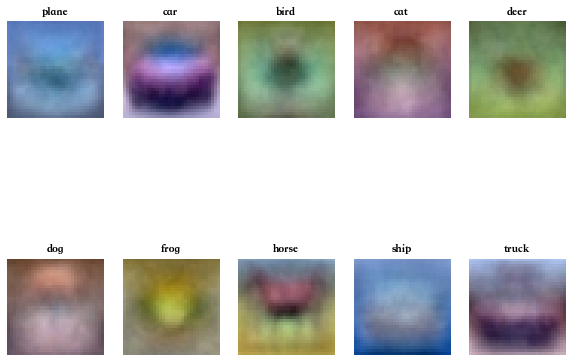

In [37]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

# 测试代码

In [23]:
X_example = np.array([[1,2,3],[4,5,6]],dtype=float) 
W_example = np.array([[0.1,0.2],[0.1,0.1],[0.1,0.1]],dtype=float) 
Y_example=[1,1]

scores = X_example.dot(W_example)
loss = np.sum(scores[range(2), Y_example]/np.sum(np.exp(scores), axis=1))
print(scores[range(2), Y_example]/np.sum(np.exp(scores), axis=1),loss)

[0.18248786 0.17013528] 0.35262314917931215
